## 01. 패키지 준비하기

In [1]:
from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler


## 02. 데이터셋 준비하기

In [2]:
origin = read_excel("../../fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


## 04. 탐색적 데이터 분석
### 상자그림

In [3]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

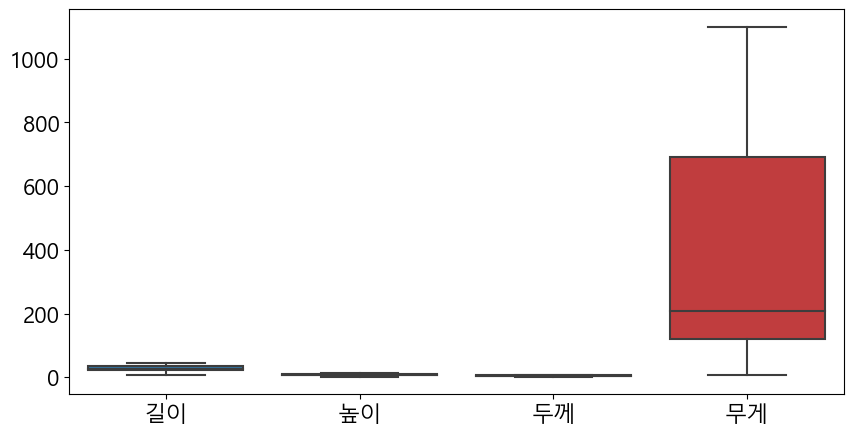

In [4]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

>데이터의 분포가 상이하므로 표준화가 필요해 보인다.

#### 산점도 그래프와 추세선 확인

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

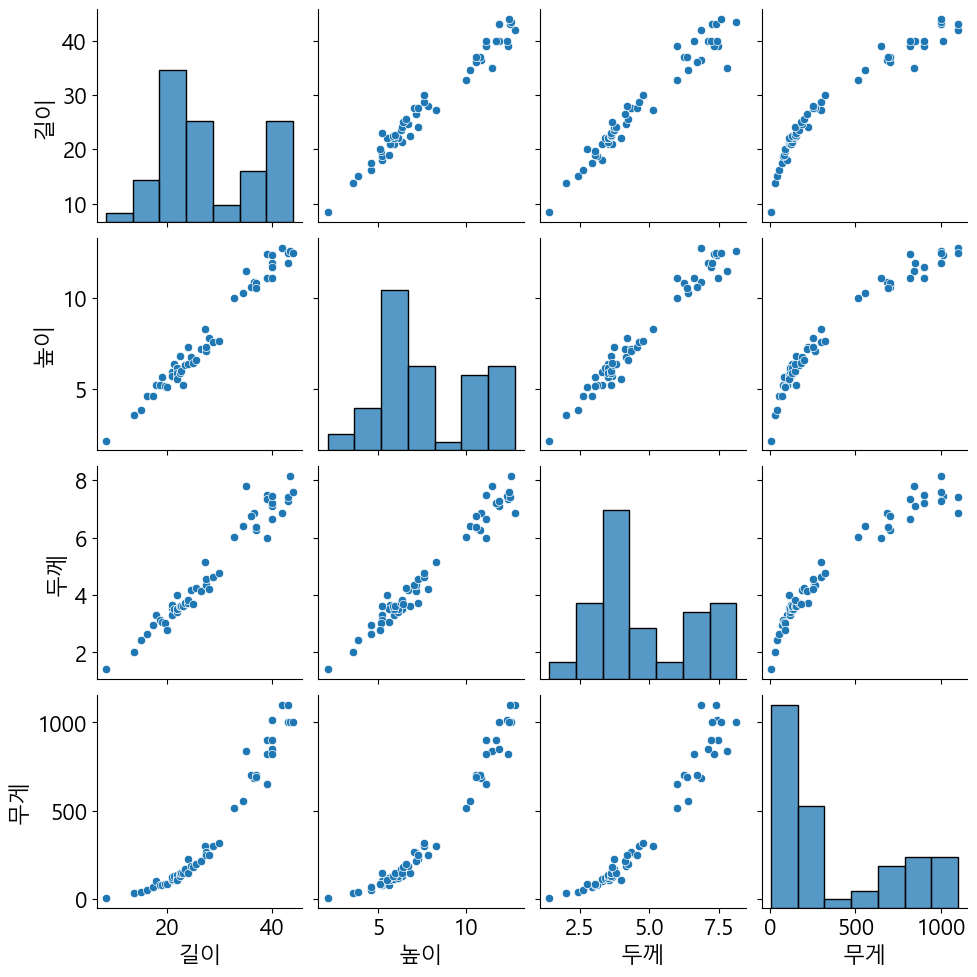

In [5]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

> Scatter Plot이 우상향의 선형 패턴을 보이기 떄문에 다중공선성이 발생할 것으로 보이고, 선형회귀보다는 다항회귀가 더 적합해 보이지만 예제를 위해 다항선형회귀로 진행하기로 함

## 05. 데이터셋 분할하기
### 랜덤시드 고정


In [6]:
np.random.seed(777)


#### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기


In [7]:
x = origin[['길이','높이','두께']]
y = origin[['무게']]
x.shape, y.shape


((56, 3), (56, 1))

#### 데이터 표준화

In [8]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((56, 3), (56, 1))

#### 표준화 전 후 상자그림 비교

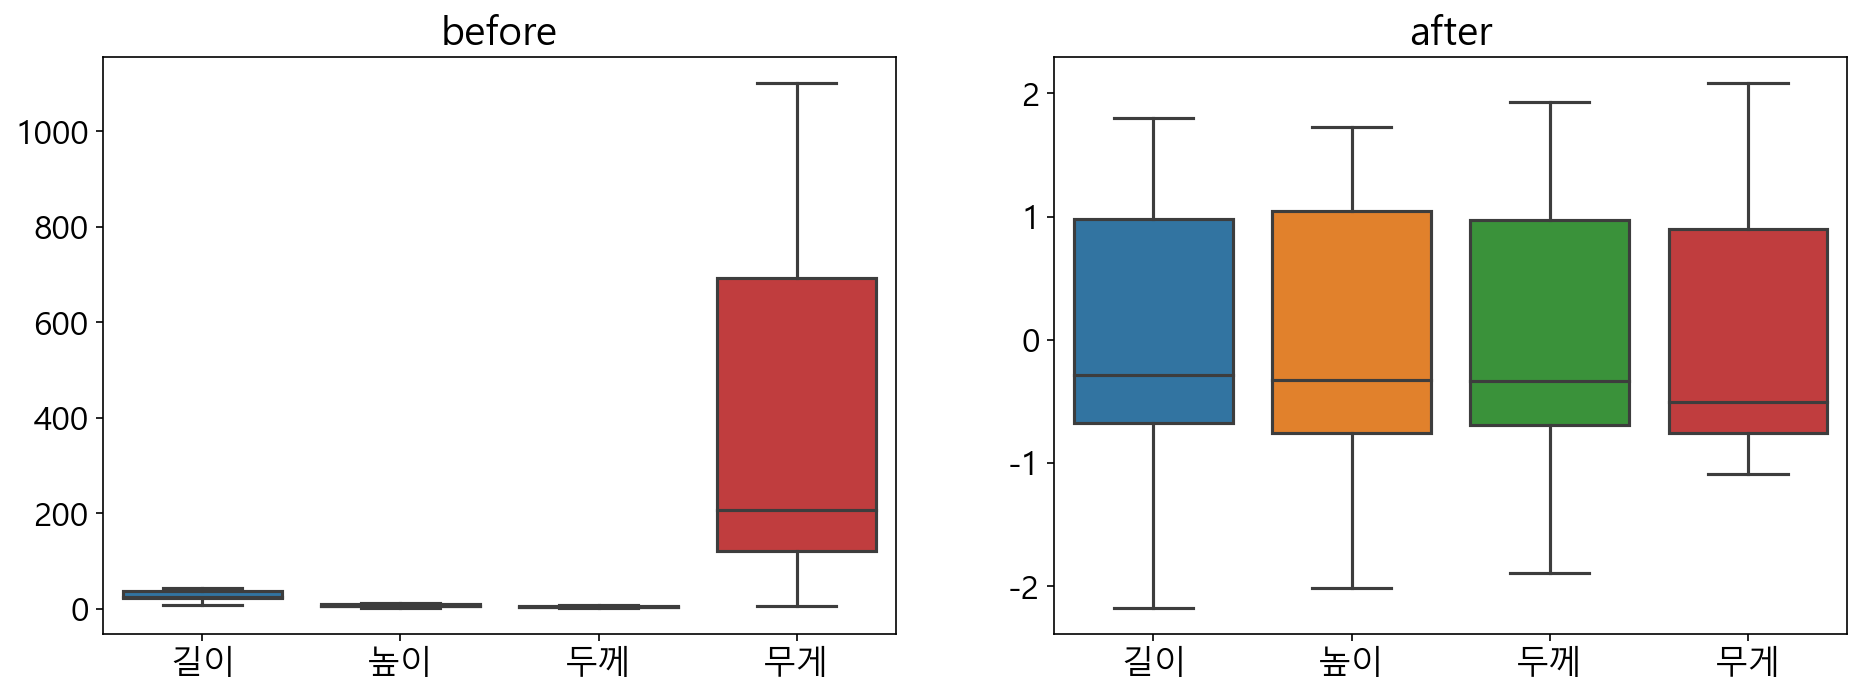

In [9]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns = ['길이', '높이', '두께'])
y_scale_df = DataFrame(y_scale, columns = ['무게'])
tmp = merge(x_scale_df, y_scale_df, left_index = True, right_index= True)

fig, ax = plt.subplots(1, 2, figsize = ( 15, 5 ), dpi = 150)
sb.boxplot(data= origin, ax=ax[0])
sb.boxplot(data=tmp, ax = ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 데이터와 검증 데이터로 분할

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size = 0.3, random_state = 777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

## 06. 모델 개발
### 모델 정의
#### 데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다

In [11]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 뉴런을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer =  'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 학습하기

In [12]:
result = model.fit(x_train, y_train, epochs = 500, validation_data= (x_test,y_test), callbacks=[
                            EarlyStopping(monitor='val_loss', patience = 10, verbose=1),
                            ReduceLROnPlateau(monitor='val_loss',patience = 3, factor = 0.5, min_lr = 0.001, verbose=1)
                            ])

Epoch 1/500
2/2 [==============================] - 1s 158ms/step - loss: 1.7132 - mae: 1.1789 - val_loss: 1.2601 - val_mae: 1.0108 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 30ms/step - loss: 1.5501 - mae: 1.1194 - val_loss: 1.1288 - val_mae: 0.9564 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 31ms/step - loss: 1.3902 - mae: 1.0597 - val_loss: 1.0099 - val_mae: 0.9045 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 35ms/step - loss: 1.2486 - mae: 1.0030 - val_loss: 0.9005 - val_mae: 0.8545 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 44ms/step - loss: 1.1100 - mae: 0.9464 - val_loss: 0.8014 - val_mae: 0.8068 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 44ms/step - loss: 0.9953 - mae: 0.8947 - val_loss: 0.7128 - val_mae: 0.7616 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 30ms/step - loss: 0.8821 - mae: 0.8422 - val_loss: 0.6335 - val_mae: 0.7184 - lr: 0.001

## 07. 학습 결과 평가

In [13]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df


,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,1.713200,1.178915,1.260114,1.010792,0.001
2,1.550142,1.119372,1.128758,0.956373,0.001
3,1.390161,1.059726,1.009931,0.904522,0.001
4,1.248575,1.002993,0.900501,0.854485,0.001
5,1.109998,0.946435,0.801421,0.806768,0.001
6,0.995313,0.894722,0.712829,0.761576,0.001
7,0.882130,0.842166,0.633500,0.718376,0.001
8,0.792304,0.794738,0.563410,0.677492,0.001
9,0.711033,0.751104,0.500584,0.638022,0.001


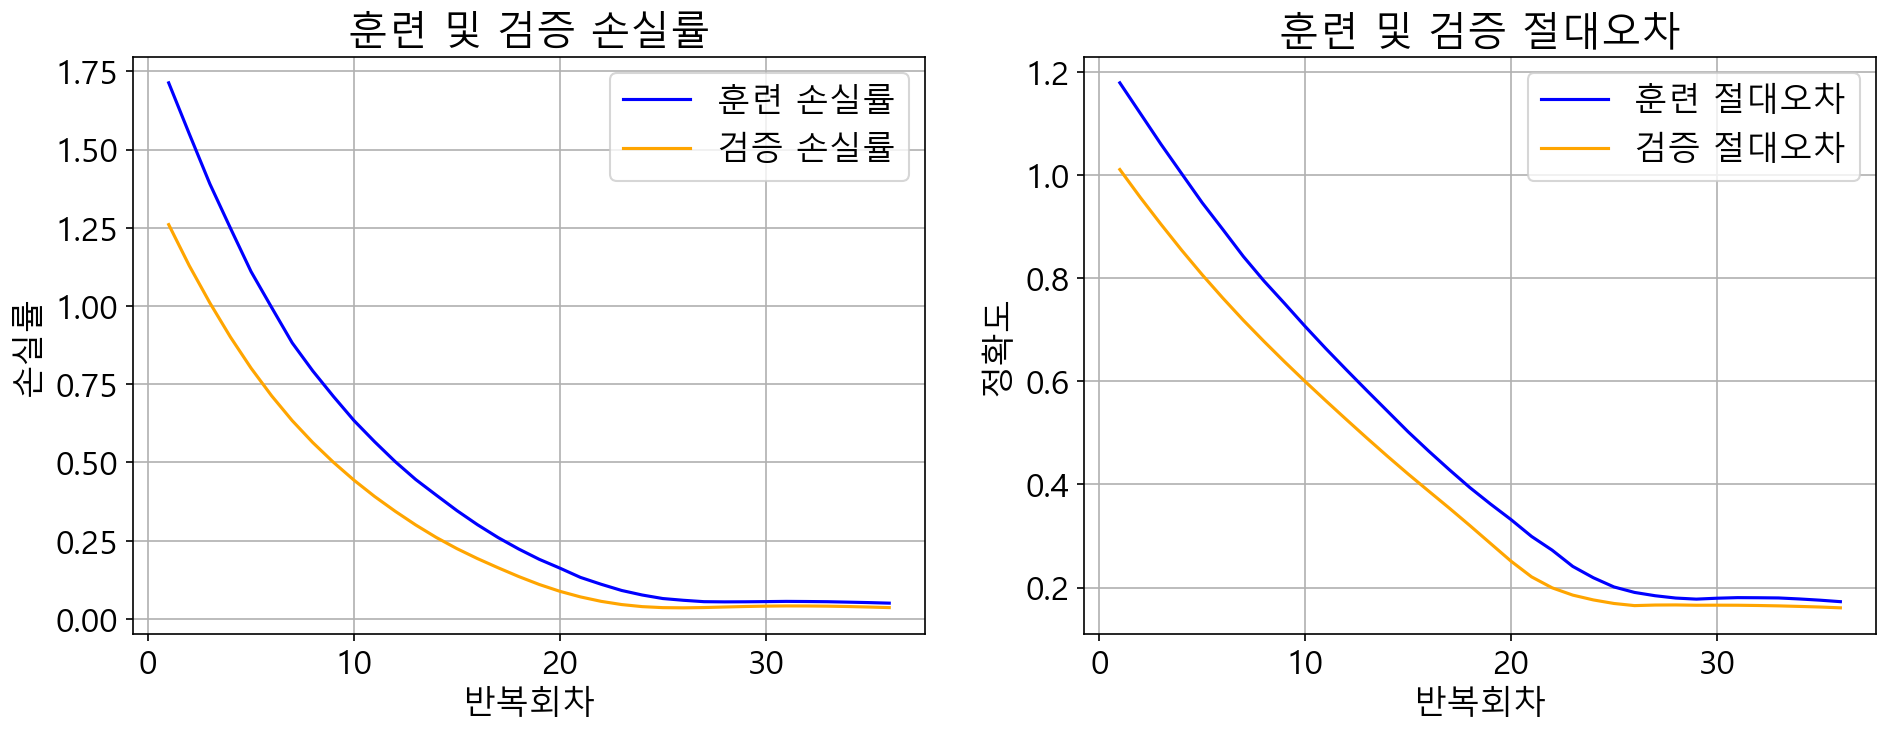

In [14]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()


In [15]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 4ms/step - loss: 0.0490 - mae: 0.1697


최종 훈련 손실률: 0.048982, 최종 훈련 절대오차: 0.169726
1/1 [==============================] - 0s 25ms/step - loss: 0.0360 - mae: 0.1607
최종 검증 손실률: 0.035956, 최종 검증 절대오차: 0.160680


In [16]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 21ms/step


In [17]:
train_df = DataFrame(x_train, columns=['길이','높이','두께'])
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()


,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.862814,-0.822640,-0.040174
1,-2.180225,-2.016507,-1.896175,-1.092422,-1.556519,0.464097
2,-0.659101,-0.779008,-0.696689,-0.761217,-0.641528,-0.119689
3,-0.368297,-0.396891,-0.327179,-0.563830,-0.415492,-0.148338
4,1.577847,1.731046,1.207709,2.083485,1.597644,0.485841


In [18]:
test_df = DataFrame(x_test, columns=['길이','높이','두께'])
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.732189,-0.632814,-0.099375
1,-0.770948,-0.761480,-0.611417,-0.746703,-0.655887,-0.090816
2,-0.580807,-0.670333,-0.634156,-0.688648,-0.589429,-0.099219
3,-0.043940,-0.204080,-0.099788,-0.383859,-0.183896,-0.199963
4,0.235678,-0.084887,0.013907,-0.180666,0.113685,-0.294350


### 실제 결과값과 머신러닝에 의한 예측값 비교


In [19]:

y =test_df['무게(관측치)']
y_pred = kdf['예측값']
coeff = np.polyfit(x,y,2)
minx= x.min()
maxx= x.max()
Vtrend = np.linspace(minx,maxx,100)
Ttrend = coeff[-1]
for i in range(0, 2):
    Ttrend += coeff[i] * Vtrend ** (2 - i)
coeff_pred = np.polyfit(x,y_pred,2)
Ttrend_pred = coeff_pred[-1]
for i in range(0,2):
    Ttrend_pred += coeff_pred[i]*Vtrend**(2-i)

NameError: name 'kdf' is not defined

In [ ]:
def getTrend(x, y, degree=2, value_count=100):
    #[ a, b, c ] ==> ax^2 + bx + c
    coeff = np.polyfit(x, y, degree)
    
    if type(x) == 'list':
        minx = min(x)
        maxx = max(x)
    else:
        minx = x.min()
        maxx = x.max()
        
    Vtrend = np.linspace(minx, maxx, value_count)
    
    Ttrend = coeff[-1]
    for i in range(0, degree):
        Ttrend += coeff[i] * Vtrend ** (degree - i)
        
    return (Vtrend, Ttrend)

In [ ]:
def regplot(x_left, y_left, y_left_pred= None, left_title = None, x_right = None, y_right = None, y_right_pred = None, right_title = None, figsize = (10,5)):
    subcount = 1 if x_right is None else 2

    fig, ax = plt.subplots(1, subcount, figsize = figsize)

    axmain = ax if subcount == 1 else ax[0]

    # 왼쪽 산점도
    sb.scatterplot(x = x_left, y = y_left, label ='data', ax = axmain)

    # 왼쪽 추세선
    x, y = getTrend(x_left, y_left)
    sb.lineplot(x=x, y=y, color = 'blue', linestyle = "--", ax = axmain)

    if y_left_pred is not None:
        sb.scatterplot(x = x_left, y = y_left_pred, label = 'predict', ax = axmain)
        x, y = getTrend(x_left, y_left_pred)
        sb.lineplot( x = x, y = y, color = 'red', linestyle = "--", ax = axmain)

    if left_title is not None:
        axmain.set_title(left_title)

    axmain.legend()
    axmain.grid()

    if x_right is not None:
        # 오른쪽 산점도
        sb.scatterplot(x = x_right,  y = y_right, label = 'data', ax = ax[1])

        # 오른쪽 추세선
        x, y = getTrend(x_right, y_right)
        sb.lineplot(x = x, y=y, color = 'blue', linestyle = '--', ax = ax[1])

        if y_right_pred is not None:
            sb.scatterplot(x = x_right, y= y_right_pred, label = 'predict' , ax=ax[1])
            # 추정치에 대한 추세선
            x, y = getTrend(x_right, y_right_pred)
            sb.lineplot(x = x, y = y, color = 'red', linestyle = "--", ax = ax[1])
        
        if right_title is not None:
            ax[1].set_title(right_title)

        ax[1].legend()
        ax[1].grid()
        
    plt.show()
    plt.close()            

    

In [ ]:
for key in ['길이','높이','두께']:
    regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))

NameError: name 'train_df' is not defined